<a href="https://colab.research.google.com/github/SaraMES/Clustering-on-Brisbane-City-bike/blob/master/citybike.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## *Clustering on Brisbane City Bike Dataset*







> Our major task here is turn data into clusters and explain what the cluster means. We will try spatial clustering.




> import of different python libraries for creating clusters



In [0]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from geopy.distance import vincenty
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
import matplotlib.cm as cm
from scipy.spatial.distance import cdist, pdist
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from mpl_toolkits.basemap import Basemap
import copy
import json
import math
from collections import OrderedDict
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# DATASET

> We’ll use Brisbane_CityBike.json only.



# A- Schema
1. Every Station’s Information

```
# number
# name
# adress
# latitude
# longiture
```




In [46]:
df_loc = pd.read_json("sample_data/Brisbane_CityBike.json")
df_loc.head()

,number,name,address,latitude,longitude
0,122,122 - LOWER RIVER TCE / ELLIS ST,Lower River Tce / Ellis St,-27.482279,153.028723
1,91,91 - MAIN ST / DARRAGH ST,Main St / Darragh St,-27.470590,153.036046
2,88,88 - SYDNEY ST FERRY TERMINAL / PARK,Sydney St Ferry Terminal / Park,-27.474531,153.042728
3,75,75 - BROWNE ST / JAMES ST,Browne St / James St,-27.461881,153.046986
4,98,98 - KURILPA POINT / MONTAGUE RD,Kurilpa Point / Montague Rd,-27.469658,153.016696


# Spatial clustering


> Using stations’ geo-information to do clustering



In [0]:
X = df_loc[['latitude', 'longitude']].values


**A. Kmeans**


> We will utilize scikit-learn function sklearn.cluster.KMeans.



```
# Parameters:
- k     (Number of clusters)
```






In [0]:
Ks = range(1, 10)
kmean = [KMeans(n_clusters=i).fit(X) for i in Ks]

**Elbow Method**
The Elbow method is a method of interpretation and validation of consistency within cluster analysis designed to help finding the appropriate number of clusters in a dataset. This method looks at the percentage of variance explained as a function of the number of clusters: One should choose a number of clusters so that adding another cluster doesn’t give much better modeling of the data.

Percentage of variance explained is the ratio of the between-group variance to the total variance.




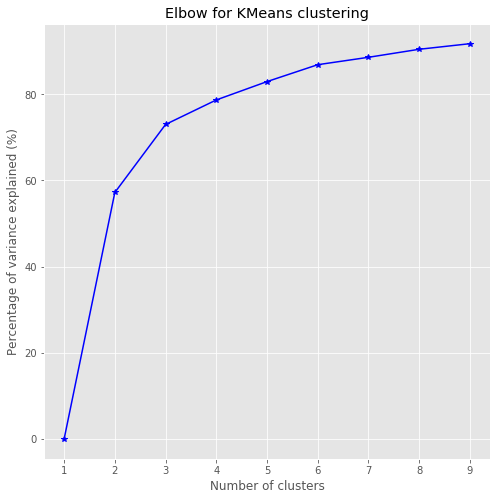

In [49]:
def plot_elbow(kmean, X):
    centroids = [k.cluster_centers_ for k in kmean]
    D_k = [cdist(X, center, 'euclidean') for center in centroids]
    dist = [np.min(D,axis=1) for D in D_k]

    # Total with-in sum of square
    wcss = [sum(d**2) for d in dist]
    tss = sum(pdist(X)**2)/X.shape[0]
    bss = tss-wcss

    plt.subplots(nrows=1, ncols=1, figsize=(8,8))
    ax = plt.subplot(1, 1, 1)
    ax.plot(Ks, bss/tss*100, 'b*-')
    plt.grid(True)
    plt.xlabel('Number of clusters')
    plt.ylabel('Percentage of variance explained (%)')
    plt.title('Elbow for KMeans clustering')
    plt.show()

plot_elbow(kmean, X)

In [0]:
def plot_stations_map(ax, stns):
    # determine range to print based on min, max lat and lon of the data
    lat = list(stns['latitude'])
    lon = list(stns['longitude'])
    margin = 0.01 # buffer to add to the range
    lat_min = min(lat) - margin
    lat_max = max(lat) + margin
    lon_min = min(lon) - margin
    lon_max = max(lon) + margin

    # create map using BASEMAP
    m = Basemap(llcrnrlon=lon_min,
                llcrnrlat=lat_min,
                urcrnrlon=lon_max,
                urcrnrlat=lat_max,
                lat_0=(lat_max - lat_min)/2,
                lon_0=(lon_max - lon_min)/2,
                projection='lcc',
                resolution = 'f',)

    m.drawcoastlines()
    m.fillcontinents(lake_color='aqua')
    m.drawmapboundary(fill_color='aqua')
    m.drawrivers()    
    
    # plot points
    clist = list(stns['cluster'].unique())
    if -1 in clist:
        clist.remove(-1)
    k = len(clist)
    colors = iter(cm.Set1(np.linspace(0, 1, max(10, k))))
    for i in range(k):
        color = next(colors)
        df = stns.loc[stns['cluster'] == clist[i]]        
        #print("Cluster {} has {} samples.".format(clist[i], df.shape[0]))
        
        # convert lat and lon to map projection coordinates
        lons, lats = m(list(df['longitude']), list(df['latitude']))        
        ax.scatter(lons, lats, marker = 'o', color=color, edgecolor='gray', zorder=5, alpha=1.0, s=15)



> Correspond to the figure above, the proper value for k may be 2, 3, or 4.

> Here I will cluster the data points using different values of k.





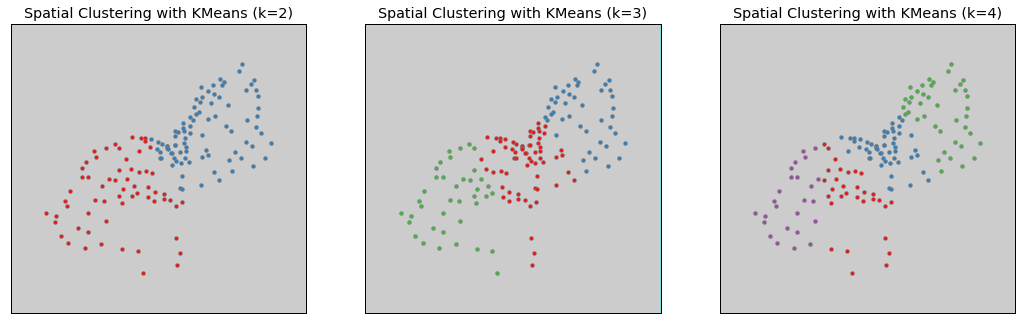

In [51]:
k = [2, 3, 4]
n = len(k)
plt.subplots(nrows=1, ncols=3, figsize=(18,15))

for i in range(n):
    est = kmean[k[i]-1]
    df_loc['cluster'] = est.predict(X).tolist()
    
    ax = plt.subplot(1, 3, i+1)
    ax.set_title("Spatial Clustering with KMeans (k={})".format(k[i]))

    plot_stations_map(ax, df_loc)



In my opinion, 3 or 4 clutsers can both well explains the geo-information of these citibike stations.

**B. DBSCAN**

>  We will utilize scikit-learn function sklearn.cluster.DBSCAN.

```
# Parameters:
- eps          (The maximum distance between two samples for them to be considered as in the same neighborhood)
- min_smaple   (The number of samples in a neighborhood for a point to be considered as a core point.)
- metric       (The metric to use when calculating distance between instances in a feature array.)
```





1. Euclidean Distance Metrics

> Euclidean distance or Euclidean metric is one of the most common distance metrics, which is the “ordinary” straight-line distance between two points in Euclidean space.

> With metric="euclidean", here I also use the combinations of different values of eps and min_sample, where eps ranges from 0.004 to 0.006 (unit: latitude/longitude) and min_sample ranges from 3 to 5.




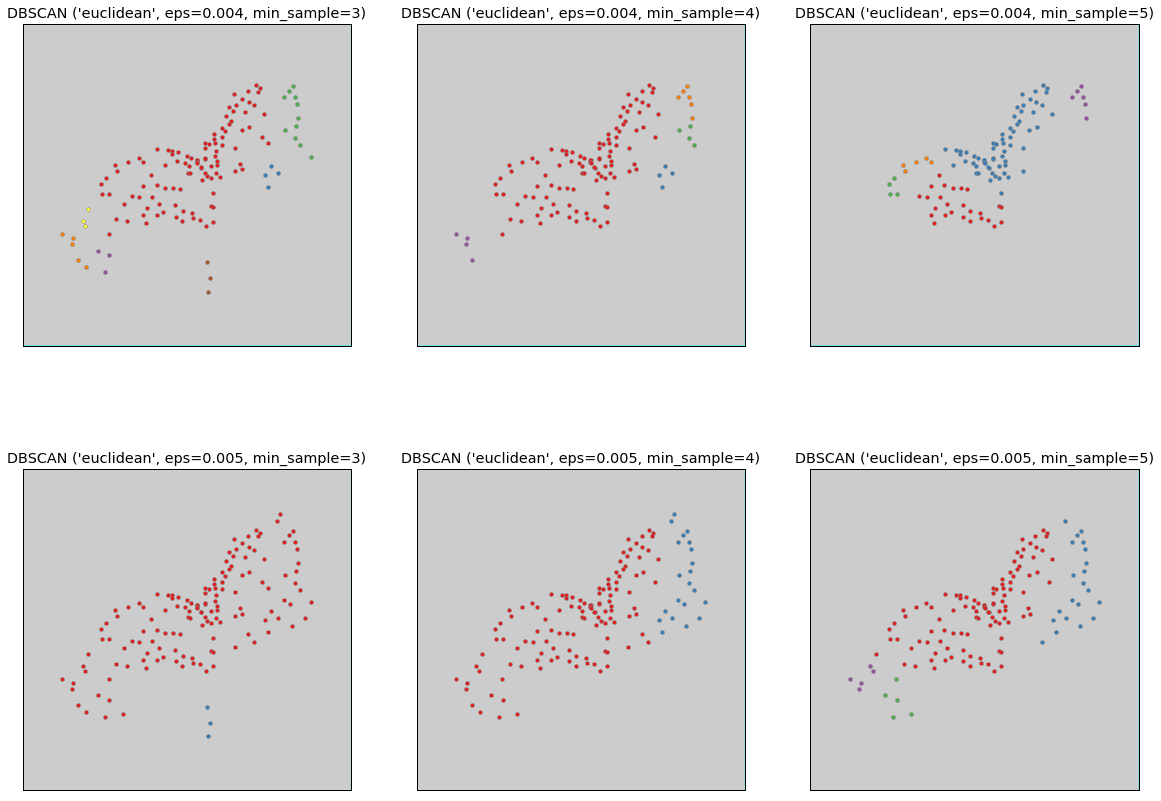

In [52]:
eps = [0.004, 0.005]   # unit: latitude/longitude
min_sample = [3, 4, 5]
n1, n2 = len(eps), len(min_sample)
plt.subplots(nrows=n1, ncols=n2, figsize=(20, 15))

for i in range(n1):
    for j in range(n2):
        est = DBSCAN(eps=eps[i], min_samples=min_sample[j], metric="euclidean").fit(X)
        df_loc['cluster'] = est.labels_.tolist()

        ax = plt.subplot(n1, n2, n2*i+j+1)
        ax.set_title("DBSCAN ('euclidean', eps={}, min_sample={})".format(eps[i], min_sample[j]))
        
        plot_stations_map(ax, df_loc)

Note that in the above figures, I only draw the core points and the boundary points. That is, you will see that some stations are missing on the map since they are consider as noise points using the specified parameters.

When eps = 0.04, this radius is so small that the clusters found are somehow too trivial. In addition, the clustering result are all similar with greater values of eps.

2. Self-defined Distance Metrics


> ince these stations are on Earth, it would be more precise if we use great-circle distance instead of Euclidean distance. The great-circle distance or orthodromic distance is the shortest distance between two points on the surface of a sphere, measured along the surface of the sphere.

> To calculate the great-circle distance, I use the function vincenty in package GeoPy.





In [0]:
def greatCircleDistance(x, y):
    lat1, lon1 = x[0], x[1]
    lat2, lon2 = y[0], y[1]
    return vincenty((lat1, lon1), (lat2, lon2)).meters

Here I also use the combinations of different values of eps and min_sample, where eps ranges from 500 to 700 (unit: meters) and min_sample ranges from 5 to 10.

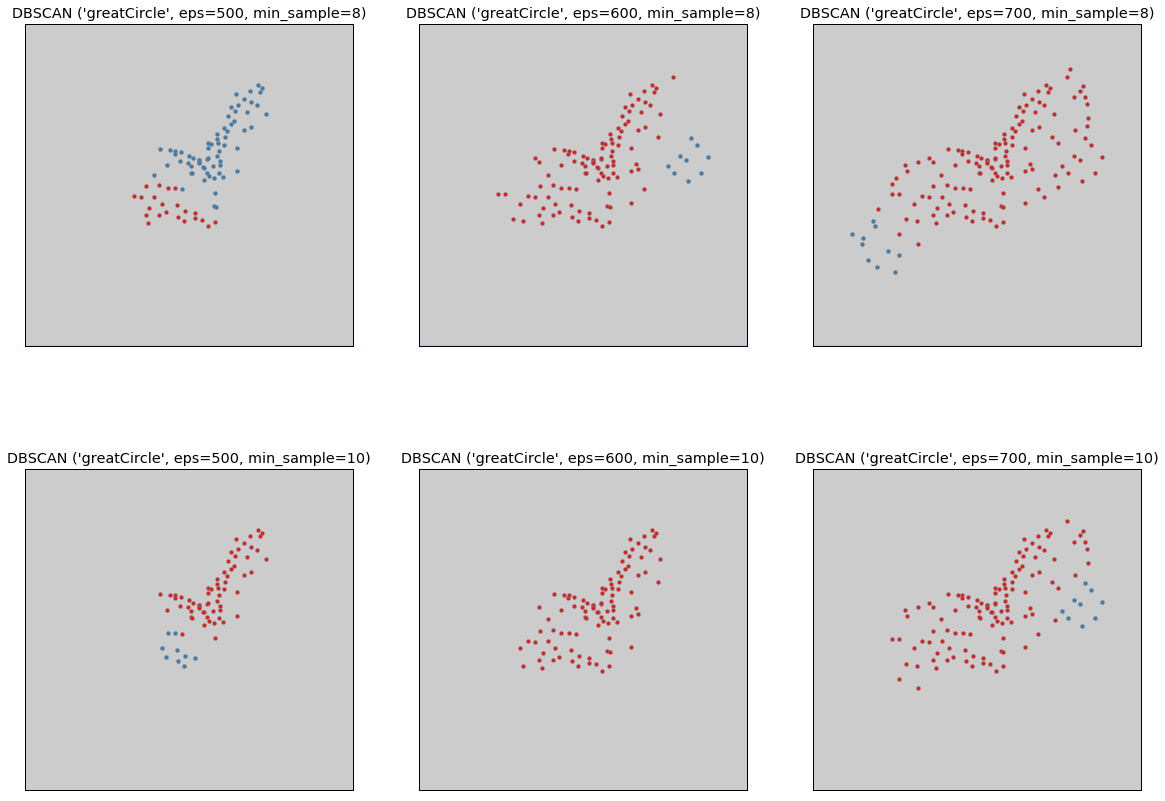

In [54]:
eps = [500, 600, 700]    # unit: meter
min_sample = [8, 10]
n1, n2 = len(eps), len(min_sample)
plt.subplots(nrows=n2, ncols=n1, figsize=(20, 15))

for j in range(n2):
    for i in range(n1):
        est = DBSCAN(eps=eps[i], min_samples=min_sample[j], metric=greatCircleDistance).fit(X)
        df_loc['cluster'] = est.labels_.tolist()

        ax = plt.subplot(n2, n1, n1*j+i+1)
        ax.set_title("DBSCAN ('greatCircle', eps={}, min_sample={})".format(eps[i], min_sample[j]))

        plot_stations_map(ax, df_loc)

The clustering result is better with the great-circle distance, which is not surprised since the length of a longitude unit is not the same as the length of a latitude unit, undoubtedly.

Furthermore, the clustering results are more meaningful. For example, see the figure at lower left, all clusters are stations that has 10 neighbors in 500 meters, so we can even conclude that these clusters are districts with high population density or high population flows.

**C. Observation & Comparisons**

> To observe and compare the clustering result of KMeans and DBSCAN with differnt parameter values, I pick some of the best clustering results from each method, which are shown in the figures below:



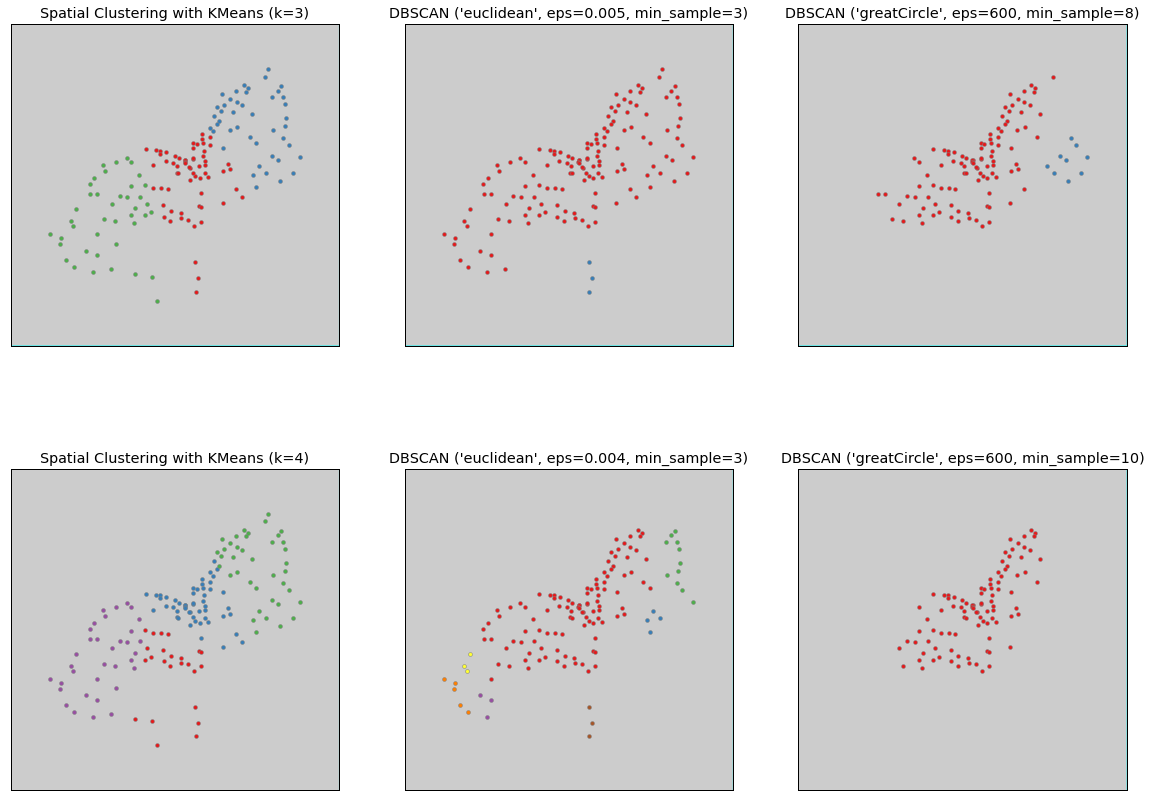

In [38]:
k = [3, 4]
euc = [(0.005, 3), (0.004, 3)]   # unit: latitude/longitude
gcd = [(600, 8), (600, 10)]    # unit: meter
plt.subplots(nrows=2, ncols=3, figsize=(20,15))

for i in range(2):
    est = kmean[k[i]-1]
    df_loc['cluster'] = est.predict(X).tolist()    
    ax = plt.subplot(2, 3, 3*i+1)
    ax.set_title("Spatial Clustering with KMeans (k={})".format(k[i]))
    plot_stations_map(ax, df_loc)
    
    est = DBSCAN(eps=euc[i][0], min_samples=euc[i][1], metric="euclidean").fit(X)
    df_loc['cluster'] = est.labels_.tolist()
    ax = plt.subplot(2, 3, 3*i+2)
    ax.set_title("DBSCAN ('euclidean', eps={}, min_sample={})".format(euc[i][0], euc[i][1]))
    plot_stations_map(ax, df_loc)
    
    est = DBSCAN(eps=gcd[i][0], min_samples=gcd[i][1], metric=greatCircleDistance).fit(X)
    df_loc['cluster'] = est.labels_.tolist()
    ax = plt.subplot(2, 3, 3*i+3)
    ax.set_title("DBSCAN ('greatCircle', eps={}, min_sample={})".format(gcd[i][0], gcd[i][1]))
    plot_stations_map(ax, df_loc)

Here are some conclusions:

1. With DBSCAN, some stations would be missing and some clusters’ sizes are too small; With KMeans, all stations would be clustered and their sizes are similar.
2. With DBSCAN, we can separate stations which are on the different side of the river; With KMeans, stations on the different side of the river can not be well-separated.
3. Using the great circle distance metrics would get more reasonable and also better clustering result.

In [55]:
df_loc

,number,name,address,latitude,longitude,cluster
0,122,122 - LOWER RIVER TCE / ELLIS ST,Lower River Tce / Ellis St,-27.482279,153.028723,0
1,91,91 - MAIN ST / DARRAGH ST,Main St / Darragh St,-27.470590,153.036046,0
2,88,88 - SYDNEY ST FERRY TERMINAL / PARK,Sydney St Ferry Terminal / Park,-27.474531,153.042728,-1
3,75,75 - BROWNE ST / JAMES ST,Browne St / James St,-27.461881,153.046986,0
4,98,98 - KURILPA POINT / MONTAGUE RD,Kurilpa Point / Montague Rd,-27.469658,153.016696,0
...,...,...,...,...,...,...
144,38,38 - ANN ST / CREEK ST,38 - Ann St / Creek St,-27.465880,153.026861,0
145,14,14 - ALBERT STREET MALL / ELIZABETH STREET,Albert St Mall / Elizabeth St,-27.470110,153.025627,0
146,45,45 - TURBOT ST / BOWEN ST,Turbot St / Bowen St,-27.462665,153.029087,0
147,1,1 - EDWARD ST / QUEEN ST,Edward St / Queen St,-27.468120,153.026820,0
